<div><img src="https://cdn.worldvectorlogo.com/logos/airbnb-2.svg", width=270, height=270, align = 'right'> 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png", width = 90, height = 90, align = 'right', style="margin:0px 25px"></div>

# Get Weird:  Find Airbnb Deals in Portland, OR with Machine Learning

This notebook runs on R with Spark 2.0.
________________________________

## Table of contents

1. [About Airbnb and Inside Airbnb](#about)
2. [Market inefficiencies?](#problemStatement)    
3. [Perform exploratory data analysis](#eda)
    * Qualitative and quantitative analysis
    * Visualization
4. [Feature selection and engineering](#featureSelection)    
5. [Modeling](#modeling)
    * Selection
    * Evaluation and prediction
6. [Data and model export](#export)
7. [Conclusion](#conclusion)

______________________

## 1. About Airbnb and Inside Airbnb<a id='about'></a>

Recently I had the pleasure of staying at my first Airbnb - a funky, cozy apartment located in downtown Denver, CO for a hundred bucks a night.  This apartment had taxidermy, zombie statuettes coming out of the dirt for potted plants, and Netflix ready to go on the TV.  The apartment immediately stood out in stark contrast to the sterile feel of a typical hotel room.  Needless to say, I was sold on the idea of using AirBnB for my travels!

Much like how Uber doesn't own any of the vehicles used by its drivers, Airbnb doesn't own any of the real estate listed on its platform.  It is essentially a brokerage between real estate owners and renters, and while users sing its praises not everyone is happy about some of the unintended consequences.  Much like Uber has wrestled with - or ignored - regulatory issues, Airbnb faces some challenges regarding zoning and other laws associated with rental properties.  For instance, there's a big difference between someone renting their house out while they go on vacation for a couple weeks and someone owning 40+ properties in NYC and simply using Airbnb to list them.  How to handle these cases is an ongoing debate.

<a href="http://www.insideairbnb.com" target="_blank" rel="noopener no referrer">Inside Airbnb</a> was created to provide visibility into the practices of Airbnb and the users who list properties with the company.  The owners of the site have scraped data from AirBnB listings and aggregated it into data sets for various cities across the USA and the world.  

### What kind of data does Inside Airbnb provide?

Each city has three data sets associated with it:

* Listings - Detailed information for each listing (beds, baths, price, etc.)
* Reviews - Feedback from those who have stayed at each listing
* Calendar - Availability for each listing

You need to download these data sets from the DSX community, which is described later [in this notebook](#download).

While Inside Airbnb uses the data to hold Airbnb accountable for its business practices, we are going to take this data and move in a decidedly more capitalist direction. 
__________

<a id='problemStatement'></a>

## 2. Market inefficiencies?

When you log into Airbnb and search the listings, it's difficult to tell whether you are getting a deal on a specific property. It can help to use reviews and the listed price, but wouldn't it be better if you knew which properties are priced below or above the market rate?  Maybe there's some listings that have everything you are looking for but are, statistically speaking, cheaper than comparable properties?  

It was this thought that leads us to the question we will ask of the data:

 > _**Can we find potential inefficiencies in an Airbnb market by learning how the features of that market impact the price?**_ 
 
In other words, we want to save money without compromising on what we're getting.  Are there any properties in the market like that?  


___________

<a id='eda'></a>
<div><img src="https://upload.wikimedia.org/wikipedia/commons/f/fb/HawthorneBridge-Pano.jpg" width = 800, height = 500, align = 'center'></div>

## 3. Perform exploratory data analysis

Now that we've defined our question we can start digging into the listings for **Portland, OR**.  We need the reviews for each listing later so let's load those now too.

### Load the data sets<a id='download'></a>

To load the data:
1. Go to the [Airbnb Data for Analytics: Portland Listings](https://apsportal.ibm.com/exchange/public/entry/view/107ab470f90be9a4815791d8ecd8b7e2) on the DSX Community. 
2. You need to save these datasets:
   - `portland-2016-01-01-calendar.csv`
   - `portland-2016-01-01-reviews.csv`
   - `portland-2016-01-01-listings.csv`
Click the download icon and save the data sets as .csv files to your computer.  
3. Load the .csv files into your notebook. Click the **Find and Add Data** icon on the notebook action bar. Drop each file into the box or browse to select the file. The file is loaded to your object storage and appears in the Data Assets section of the project. For more information, see <a href="https://datascience.ibm.com/docs/content/analyze-data/load-and-access-data.html" target="_blank" rel="noopener noreferrer">Load and access data</a>.
4. To load the data from the `portland-2016-01-01-calendar.csv` file into a R DataFrame, click in the next code cell and select **Insert to code > Insert R DataFrame** under the file name.
6. Run the cell.


In [ ]:
# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
 

In [1]:
       
# Load libraries, suppressing messages for cleaner output
suppressWarnings(suppressMessages(install.packages('lme4')))
suppressWarnings(suppressMessages(install.packages('arm')))
suppressWarnings(suppressMessages(install.packages('devtools')))
suppressWarnings(suppressMessages(install.packages('merTools')))
suppressWarnings(suppressMessages(library(dplyr)))
suppressWarnings(suppressMessages(library(ggplot2)))
suppressWarnings(suppressMessages(library(caret)))
suppressWarnings(suppressMessages(library(lme4)))
suppressWarnings(suppressMessages(library(arm)))
suppressWarnings(suppressMessages(library(gridExtra)))
suppressWarnings(suppressMessages(install.packages("Imap")))
suppressWarnings(suppressMessages(library(merTools)))
suppressWarnings(suppressMessages(library(Imap)))
suppressWarnings(suppressMessages(library(httr)))
suppressWarnings(suppressMessages(library(RCurl)))
suppressWarnings(suppressMessages(library(bitops)))
suppressWarnings(suppressMessages(library(devtools)))
suppressWarnings(suppressMessages(library(repr)))

## Source geographic distance calculation functions
suppressWarnings(suppressMessages(source_url("https://gist.githubusercontent.com/kurlare/f1362c1ba1c4c0df0b081d44ec5e90eb/raw/000c0ee61e3a2a0bd3668e5f44601ceccb958176/geodistance.R")))

Loading required package: httr
Loading required package: RCurl
Loading required package: bitops

Attaching package: ‘RCurl’

The following object is masked from ‘package:SparkR’:

    base64



listing_id,date,available,price
4917894,2016-01-01,f,
4917894,2016-01-02,t,$85.00
4917894,2016-01-03,f,
4917894,2016-01-04,f,
4917894,2016-01-05,f,
4917894,2016-01-06,f,


Load `portland-2016-01-01-reviews.csv` and `portland-2016-01-01-listings.csv`.

In [2]:
# @hidden_cell
# This function accesse files in your Object Storage. The definitions contain your credentials.
 
## Load Reviews

## Load Listings

## Load Reviews
head(portland)

id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
4917894,https://www.airbnb.com/rooms/4917894,2.01601e+13,2016-01-01,Private suite near it all- Room #1,"Private queen suite/full private bathroom with everything you need! Huge common kitchen, living room, porch, etc. Short walk to Lloyd and Moda Center, LightRail, downtown, 28th, Broadway, shops, bars and restaurants. Other rooms available!","-Private Suite in larger 7 bed, 6 bathroom home. -Sleeps two in a queen bed. -Private full bath in your suite stocked with natural shampoo, conditioner, body wash, hand soap, towels, wash cloth, hair dryer, Q-tips and cotton balls. -Private sunroom between your bedroom and bathroom. -Your keys will be waiting for you in the door lock of your room. -Dresser, closet, luggage rack, seating, extra blankets. -Extra linens in hall closet. -High ceilings. Comfortable spaces.","Private queen suite/full private bathroom with everything you need! Huge common kitchen, living room, porch, etc. Short walk to Lloyd and Moda Center, LightRail, downtown, 28th, Broadway, shops, bars and restaurants. Other rooms available! -Private Suite in larger 7 bed, 6 bathroom home. -Sleeps two in a queen bed. -Private full bath in your suite stocked with natural shampoo, conditioner, body wash, hand soap, towels, wash cloth, hair dryer, Q-tips and cotton balls. -Private sunroom between your bedroom and bathroom. -Your keys will be waiting for you in the door lock of your room. -Dresser, closet, luggage rack, seating, extra blankets. -Extra linens in hall closet. -High ceilings. Comfortable spaces. Full living area on main floor including kitchen, living room front porch with swing, Laundry in basement with iron and board. Coffee and tea provided in the kitchen. Make it yourself. Ample free street parking with no time limits. On a quiet side street. Lock bikes on racks",none,"Close enough to walk to everything! 85 walk score. 74 Transit score. 100 bike score. -5 blocks from MAX LightRail. -2 blocks from many bus routes. -Easy location to get a cab. - Lloyd Center - Moda/Convention Center -Shops, bars and restaurants on Broadway, 28th St.,and Vancouver/Williams only blocks away -Also close enough to Mississippi and most of the SE neighborhoods. Check out Swift or Iconic for drinks only a block away!",...,9,t,,"OREGON, MULTNOMAH, PORTLAND",t,flexible,f,f,5,5.09
3635579,https://www.airbnb.com/rooms/3635579,2.01601e+13,2016-01-01,Spacious Room & Private Bath,An artist's home with spacious bedroom and private bath. Come here to experience the heart of Portland.,"The house is in authentic, inviting 1906 Portland Craftsman. This a spacious, comfortable first floor room with a private bath/tub room that fits up to two people. It comes with a wardrobe and hangers, side tables, drawers and a full length mirror. The house has large windows everywhere with plenty of shared spaces for hanging out with WIFI. This is a 420 friendly household. If imbibing, respectfully, please do so on the side porch or in the back yard.","An artist's home with spacious bedroom and private bath. Come here to experience the heart of Portland. The house is in authentic, inviting 1906 Portland Craftsman. This a spacious, comfortable first floor room with a private bath/tub room that fits up to two people. It comes with a wardrobe and hangers, side tables, drawers and a full length mirror. The house has large windows everywhere with plenty of shared spaces for hanging out with WIFI. This is a 420 friendly household. If imbibing, respectfully, please do so on the side porch or in the back yard. You will have full access to the kitchen, dining room, living room, seating and table on back porch as well as back yard table and gas grill

As you can see, the data set contains a fair amount of detail for each listing.  To help us decide which fields to focus on, let's take a step back and ask ourselves this simple question:

### What drives real estate prices?

In conjunction with quantitative analysis of the data we are going to approach the problem on a conceptual, qualitative level. Without looking at the data, what are the primary drivers of price in real estate?  

Yes, there's the famous adage _"Location, location, location!"_.  It's undeniable that Midtown Manhattan properties command a higher price than the suburbs of Portland.  However, there's another obviously important and intuitive driver of price:  _"Bedrooms, bathrooms, square footage!"_  Even within one geographic location, prices vary based on the accommodations and type of property.  

With that said it's time to examine the relationship between price and size and location in our data set. We don't have square footage but we do have `accommodates`, a field that estimates how many people can stay at a property.

In [3]:
## Reformat `price` field to integer
portland$price <- gsub(",", "", portland$price)
portland$price <- as.integer(gsub("\\$", "", portland$price))

## Select fields relating to location and size
portland <- dplyr::select(portland, 
                          id, latitude, longitude, city, neighbourhood_cleansed, zipcode,
                          property_type, room_type, accommodates, bathrooms, 
                          bedrooms, beds, amenities, description, price)

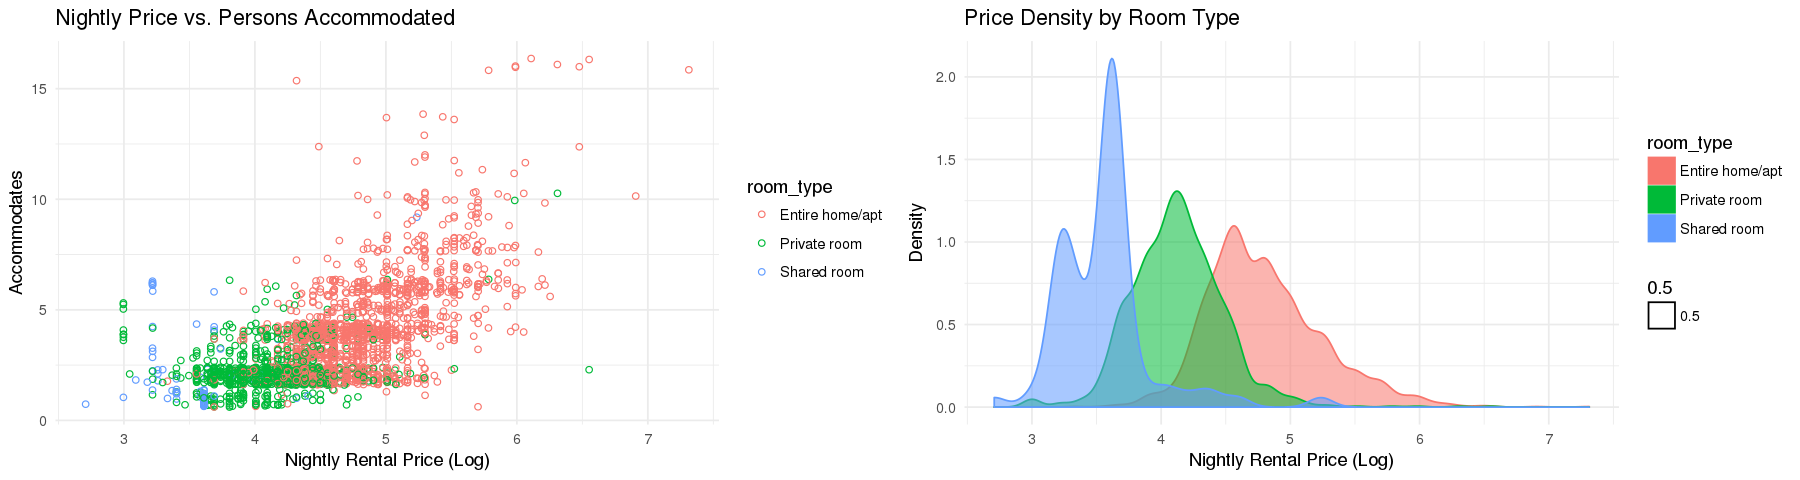

In [4]:
## Visualize Price vs. Accommodates
options(repr.plot.width=15, repr.plot.height=4)
p1 <- ggplot(portland, aes(x = log(portland$price),  y = accommodates, color = room_type)) + geom_point(position = 'jitter', shape = 1) + 
        labs(x = "Nightly Rental Price (Log)", y = "Accommodates", title = "Nightly Price vs. Persons Accommodated") + theme_minimal()
p2 <- ggplot(portland, aes(x = log(portland$price), color = room_type)) + geom_density(aes(fill = room_type, alpha = 0.5)) + 
        labs(x = "Nightly Rental Price (Log)", y = "Density", title = "Price Density by Room Type") + theme_minimal() 
grid.arrange(p1, p2, ncol = 2, nrow = 1)

The above plots show us that indeed, larger accommodations generally fetch a higher price.  What about location?  Here are the average prices for a number of neighborhoods with at least 30 listings. 

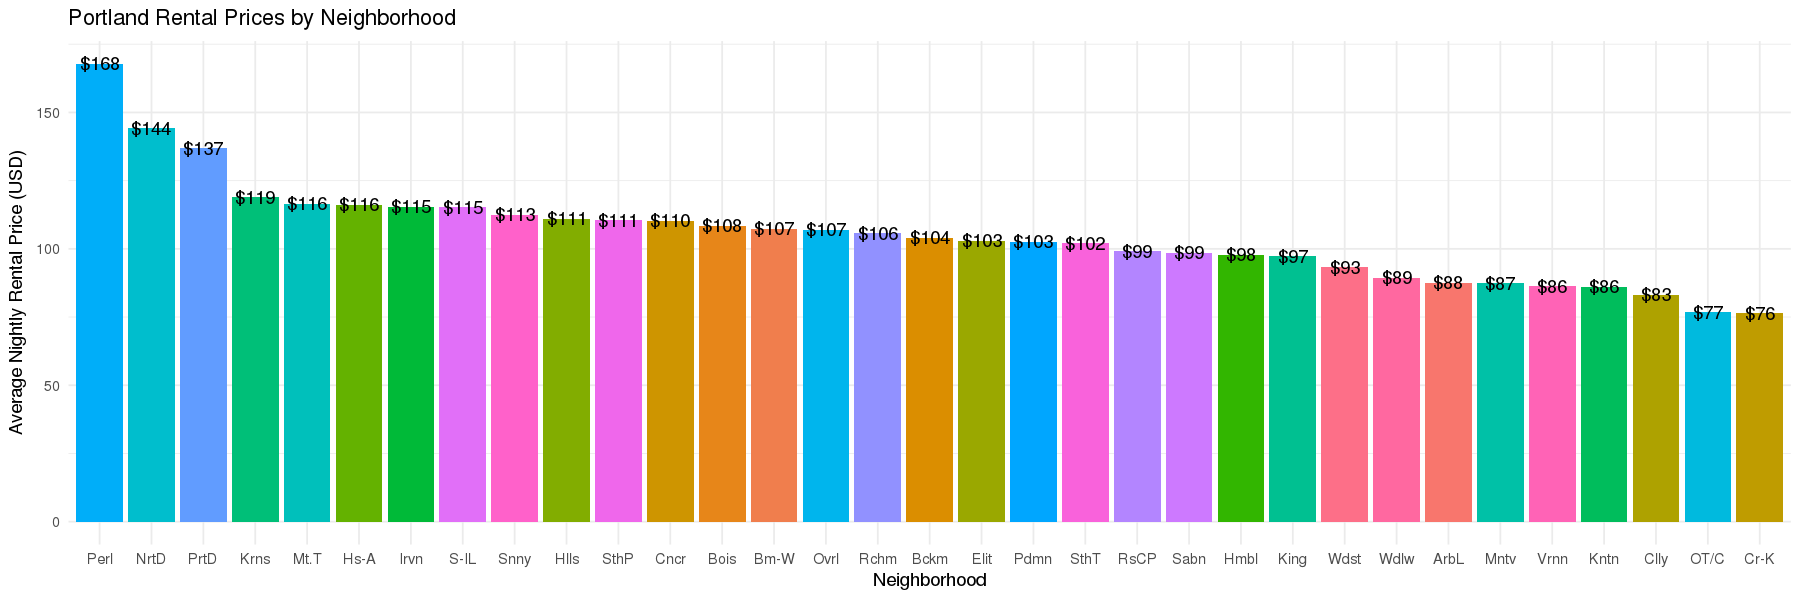

In [5]:
pAggs <- group_by(portland, neighbourhood_cleansed) %>% 
            summarise(avg_price = mean(price), count = n()) %>% 
            filter(count > 29) %>% 
            arrange(desc(avg_price))

options(repr.plot.width=15, repr.plot.height=5)

ggplot(pAggs, aes(x = reorder(neighbourhood_cleansed, -avg_price), y = avg_price, fill = neighbourhood_cleansed)) + 
    geom_bar(stat = "identity") + 
    geom_text(label = paste0("$", round(pAggs$avg_price))) + 
    scale_x_discrete(label = abbreviate) + 
    labs(x = "Neighborhood", y = "Average Nightly Rental Price (USD)", title = "Portland Rental Prices by Neighborhood") + 
    theme_minimal() + 
    theme(legend.position = "none")

As you can see, there's a nice spread of prices across neighborhoods in Portland.  I think this confirms our intuition that location and size play an important role in determining the price of a rental.  

Let's walk through some of the data preparation that was done for modeling.

__________

### Yurtlandia?

It wouldn't be Portland if you couldn't find a <a href="https://en.wikipedia.org/wiki/Yurt" target="_blank" rel="noopener no referrer">yurt</a> to stay in: 

In [6]:
portland[portland$property_type == "Yurt", c("id", "description")]

,id,description
964,4813968,"Our yurt home is walkable to the fun and funky Mississippi, Alberta, and Williams districts. It sleeps 4 (1 Queen bed, 1 full futon) and has a private bath in a home under renovation. It's the perfect rustic city retreat! Our yurt is bright and full of rustic charm and character. It's located next to our guest house that we own and run, which you will have access to. Your bathroom is an adventure as it's located in the house the yurt is behind, which has had the walls removed for renovation scheduled to begin in the winter 2016. However, the bathroom space itself is clean with great hot water and pressure and. There will not be construction when our guests are here. -Three blocks south of Yurtlandia is the vibrant Mississippi Avenue. 1/2 mile SE is the Williams District. 1 mile east is Alberta Arts District. This area has enough shopping, pubs, microbrews, cafes, restaurants, and food carts to keep you busy for days in the Mississippi District alone! -We are a Bike Friend"


Perhaps you'd prefer an "Earth House" or treehouse?  The choice is yours!  Unfortunately, there aren't enough data points to support modeling these property types as their own category so we are going to roll them up into "Other".

In [7]:
## Roll up property types with few listings into 'Other'
others <- subset(count(portland, property_type), n <= 10)$property_type
portland[portland$property_type %in% others, "property_type"] <- "Other"

_____
### Dubious accommodations

During the initial model testing phase, I looked at some of the predictions with the worst accuracy. This is what I discovered:

In [8]:
portland[portland$id %in% c(7263634, 628230), c("id", "neighbourhood_cleansed", "property_type", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "description")]

,id,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,description
1311,7263634,Northwest District,Loft,Entire home/apt,16,1.0,0,1,"Whether you're hosting a business function or a private party, Soltesz Fine Art on NW 23rd is the perfect spot for your next event. Whether you're hosting a business function or a private party, Soltesz Fine Art on NW 23rd is the perfect spot for your next event. The 2800 sq ft industrial space features endless natural light, with its two walls of windows, concrete floors, a garage door in front, private outdoor access in the rear and, best of all world class art. The gallery also has a parking lot for easy access. Parking lot next to the gallery $5000 for the day. Evening rates also available."
1855,628230,Portland Downtown,Other,Entire home/apt,16,0.5,NA,1,"The Portland Wine Bar, located directly across from Pioneer Courthouse Square, is an ideal location for exploring the city and a central meeting place. Great for a tasting, flight, glass of wine, it features small, handcrafted local wines. Note: Rate listed is hourly, NOT daily. Send me message with your group size and length of time desired please and I will to ode you a quote based on the rental rates below. The Portland Wine Bar is a wine bar, winery tasting room and wine bottle shop that showcases unique, small ferments from Oregon and Washington State wine regions. We are located in the heart of downtown Portland, Oregon, right next to Pioneer Courthouse Square at 526 Yamhill Street. We carry small production, limited quantity, local wines you will not find in a chain grocery store. We feature our house winery labels, Bodhichitta Winery and Island Mana Wines. Bodhichitta was founded in Salem, Oregon, in 2009, by owner/winemaker, Mark Proden. The Island Mana line was b"


It turns out that businesses were listing their spaces on Airbnb.  As someone looking for a place to stay or price my rental property, these data points do not interest me!  To handle these cases I'm going to drop any rows where the number of people accommodated is greater than eight, but the number of beds is less than or equal to two.  

In [9]:
## Not all listings are for overnight stays.  Remove likely meeting/event spaces.
portland <- portland[!(portland$accommodates > 8 & portland$beds <=2), ]

_____

### Handling 'hoods

Another problem I ran into was that certain neighborhoods only had a handful of listings.  With so few observations in the group, I needed a way to have nearby neighborhoods swallow up those with few listings.  To do this I grouped the data by neighborhood then found the average latitude and longitude.  Once I had those coordinates I could calculate the distances between each set of points, with the smallest distance being equivalent to the nearest neighbor.  Then any neighborhoods with less than 30 listings are reassigned (aka 'swallowed up') by their nearest neighbor.  

In [10]:
## Roll up neighborhoods with few listings into closest neighbors
## find neighbourhood average lat/long
coords <- group_by(portland, neighbourhood_cleansed) %>% summarise(lat = mean(latitude), lon = mean(longitude)) 
coords <- left_join(coords, count(portland, neighbourhood_cleansed), by = 'neighbourhood_cleansed')
counts <- coords$n

## Calculate the distances between each neighborhood
distances <- suppressWarnings(GeoDistanceInMetresMatrix(coords[, c("lat", "lon", "neighbourhood_cleansed")]))
colnames(distances) <- coords$neighbourhood_cleansed
rownames(distances) <- coords$neighbourhood_cleansed
#distances <- cbind(as.data.frame(distances), hoods, counts = coords$n)

## Identify the closest neighbor
min_distances <- apply(distances, 1, function(x) order(x, decreasing=F)[2])
hoods <- data.frame(neighbourhood_cleansed = names(min_distances),
                    count = counts,
                    nearest_id = min_distances,
                    row.names = NULL)

coords <- as.data.frame(coords)
coords$above30 <- as.factor(ifelse(coords$n >=30, "Y", "N"))
hoods$nearest_neighbor <- coords[hoods$nearest_id, "neighbourhood_cleansed"]

Plotting the average lat/long for each neighborhood before and after this process, you can see how we shrunk the number of neighborhoods from 91 to 68.

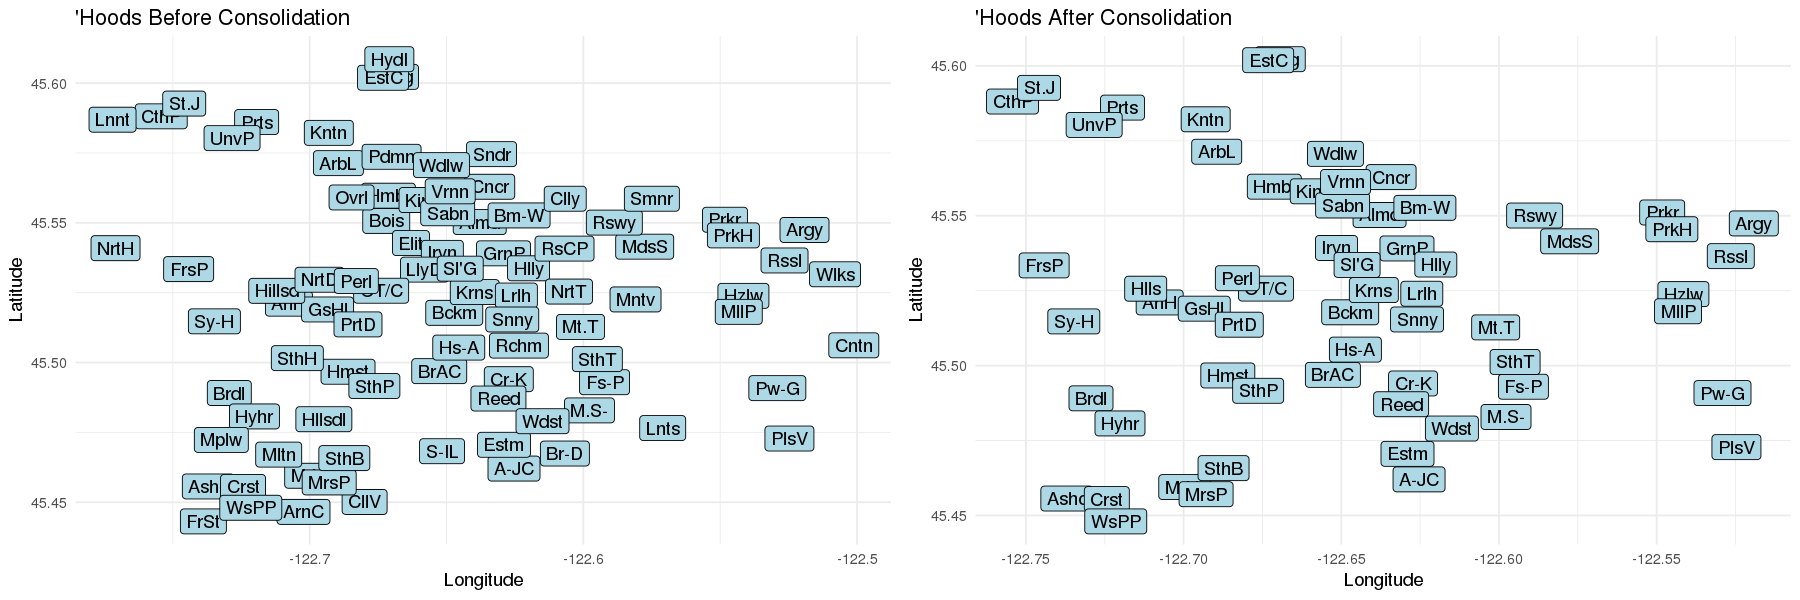

In [11]:
p1 <- ggplot(coords, aes(x = lon, y = lat)) + geom_label(label = abbreviate(coords$neighbourhood_cleansed), fill = 'lightblue') + 
        labs(x = "Longitude", y = "Latitude", title = "'Hoods Before Consolidation") + theme_minimal()


p2 <- ggplot(coords[coords$neighbourhood_cleansed %in% hoods$nearest_neighbor, ], aes(x = lon, y = lat)) + 
        geom_label(label = abbreviate(coords[coords$neighbourhood_cleansed %in% hoods$nearest_neighbor, "neighbourhood_cleansed"]), fill = 'lightblue') +
        labs(x = "Longitude", y = "Latitude", title = "'Hoods After Consolidation") + theme_minimal()
grid.arrange(p1, p2, ncol = 2, nrow = 1)

It would be nice to iterate over this until there were at least 30 observations in each neighborhood, but due to time constraints I'll have to be satisfied with only once.

In [12]:
## Reassign neighborhoods with very few listings to their nearest neighbor
portland <- left_join(portland, hoods, by = 'neighbourhood_cleansed')
portland[portland$count < 30, "neighbourhood_cleansed"] <- portland[portland$count < 30, "nearest_neighbor"]

<a id='featureSelection'></a>

_______

## 3. Feature  selection and engineering

We understand the impact of size and location on price, so our features will focus on those two categories.  

### CompositeSize and price skew
To tackle the problem of listings overstating their accommodations, we created a new feature called `compositeSize`.  The idea behind the feature is that it combines the various size-related variables into a single one to mitigate or prevent collinearity.  To do that we run a simple OLS model that gives a rough estimate of the relative effects of each size-related variable on rental price.  Then we take an average of those size-related variables, weighting them by the estimates of their relative effects on rental price.  

Before we create that simple model we'll log-transform the prices to reduce skew.

In [13]:
## Let's take the log of price to deal with skew
portland$log_price <- log(portland$price)

## Create a simple model to get the coefficients for accommodations
subMod <- lm(log_price ~ accommodates + bathrooms + bedrooms, data = portland)

## Create a compositeSize feature that penalizes large 'accommodates' values without
## corresponding beds and baths.
portland$compositeSize <- (portland$accommodates * subMod$coefficients[[2]] + 
                           portland$bathrooms * subMod$coefficients[[3]] + 
                           portland$bedrooms * subMod$coefficients[[4]])/sum(subMod$coefficients[[2]], subMod$coefficients[[3]], subMod$coefficients[[4]])


### Feature subset

Finally, we'll create our modeling dataframe by subsetting the columns that we'll use to predict price.

In [14]:
## Subset for modeling
modelingDF <- na.omit(dplyr::select(portland,
                                    neighbourhood_cleansed, property_type, room_type, accommodates, 
                                    bathrooms, bedrooms, beds, compositeSize, log_price, id))

<a id='modeling'></a>

_________

## 4. Modeling

Now that we have explored and prepared the data, it's time to get down to modeling.  

### Selection

Since we are interested in trying to predict the price of a rental property this is essentially a regression problem.  After trying numerous methods, I settled on using a mixed-effects model in R from the `lme4` package.  Why did I settle on this model versus something like random forest, xgboost, or some other algorithm?  Good question.

Going back to our qualitative analysis, we believe that size and location matter when it comes to price.  More specfically, the location - such as neighborhood - has an impact on how much size contributes to the final cost.  Think of it this way... each bedroom in a cheaper neighborhood contributes less to the overall price than each bedroom in an expensive neighborhood.  If this is true then we don't want one coefficient for the 'bedrooms' feature.  We want the coefficient for bedrooms to vary with what neighborhood it is in.  Mixed-effects models allow us to do this!  If you'd like to know more there's some <a href="https://www.jaredknowles.com/journal/2013/11/25/getting-started-with-mixed-effect-models-in-r" target="_blank" rel="noopener no referrer">excellent documentation</a> about how to build these types of models by Jared Knowles.  

After extensive testing and many permutations, **the final model we settled on treats each neighborhood as its own group and allows the coefficient of one of our size metrics to vary based on neighborhood.  It also treats each property type-room type combination as a group, with varying coefficients for size.**

There may be a better way to formulate this qualitative/quantitative relationship, but the results from this model are encouraging.  Having said all that, let's create that model and start evaluating it.

In [15]:
## Split into train, test, and validation sets
set.seed(22)
modelingDF$index <- 1:nrow(modelingDF)
trainDF <- sample_frac(modelingDF, 0.8)
tempDF <- modelingDF[-trainDF$index, ]
testDF <- sample_frac(tempDF, 0.6)
validationDF <- tempDF[!(tempDF$index %in% testDF$index), ]

## Make sure factor levels are consistent across data partitions
totalData <- rbind(trainDF, testDF, validationDF)
for (f in 1:length(names(totalData))) {
  levels(trainDF[, f]) <- levels(totalData[, f])
  levels(testDF[, f]) <- levels(totalData[, f])
  levels(validationDF[, f]) <- levels(totalData[, f])
}

## Multi-level model treats each 'hood as its own group with its own relationship to price, 
## and allows the slope of compositeSize to vary between 'hoods.  It also treats each
## property type and room type combination as a group and allows the slope of accommodates to vary for 
## those groups.
portMod <- lmer(log_price ~ (1 + compositeSize | neighbourhood_cleansed) +
                            (1 + accommodates | property_type/room_type) +
                            bathrooms + bedrooms + room_type + accommodates,
                data = trainDF)

### Evaluation and prediction

It isn't always obvious how to define 'accuracy' in machine learning because it depends on the data you are working with and the question you are trying to answer.  In this case we're trying to identify properties that fall outside of a likely range.  **Specifically, any listed price that falls outside of the 95% confidence intervals for the predicted price will be considered 'mispriced'.**  We'll evaluate our model with the traditional metrics, but keep in mind that at the end of the day we'll be happy if we can identify potentially mispriced listings.  

In [16]:
## Evaluate model AIC (lower is better)
display(portMod)

## Predict prices with confidence intervals at 95%
preds <- suppressWarnings(predictInterval(merMod = portMod, newdata = testDF, 
                                          level = 0.95, n.sims = 10000,
                                          stat = "median", type="linear.prediction",
                                          include.resid.var = TRUE,
                                          seed = 206))

## Check RMSE
postResample(exp(preds$fit), exp(testDF$log_price))

lmer(formula = log_price ~ (1 + compositeSize | neighbourhood_cleansed) + 
    (1 + accommodates | property_type/room_type) + bathrooms + 
    bedrooms + room_type + accommodates, data = trainDF)
                      coef.est coef.se
(Intercept)            4.11     0.11  
bathrooms              0.14     0.02  
bedrooms               0.16     0.01  
room_typePrivate room -0.48     0.02  
room_typeShared room  -1.16     0.05  
accommodates           0.07     0.04  

Error terms:
 Groups                  Name          Std.Dev. Corr  
 neighbourhood_cleansed  (Intercept)   0.18           
                         compositeSize 0.03     -0.77 
 room_type:property_type (Intercept)   0.19           
                         accommodates  0.10     -1.00 
 property_type           (Intercept)   0.23           
                         accommodates  0.07     -1.00 
 Residual                              0.30           
---
number of obs: 2259, groups: neighbourhood_cleansed, 66; room_type:proper

RMSE   Rsquared 
64.2933018  0.5188749

Not too bad.  Let's evaluate the model performance visually.

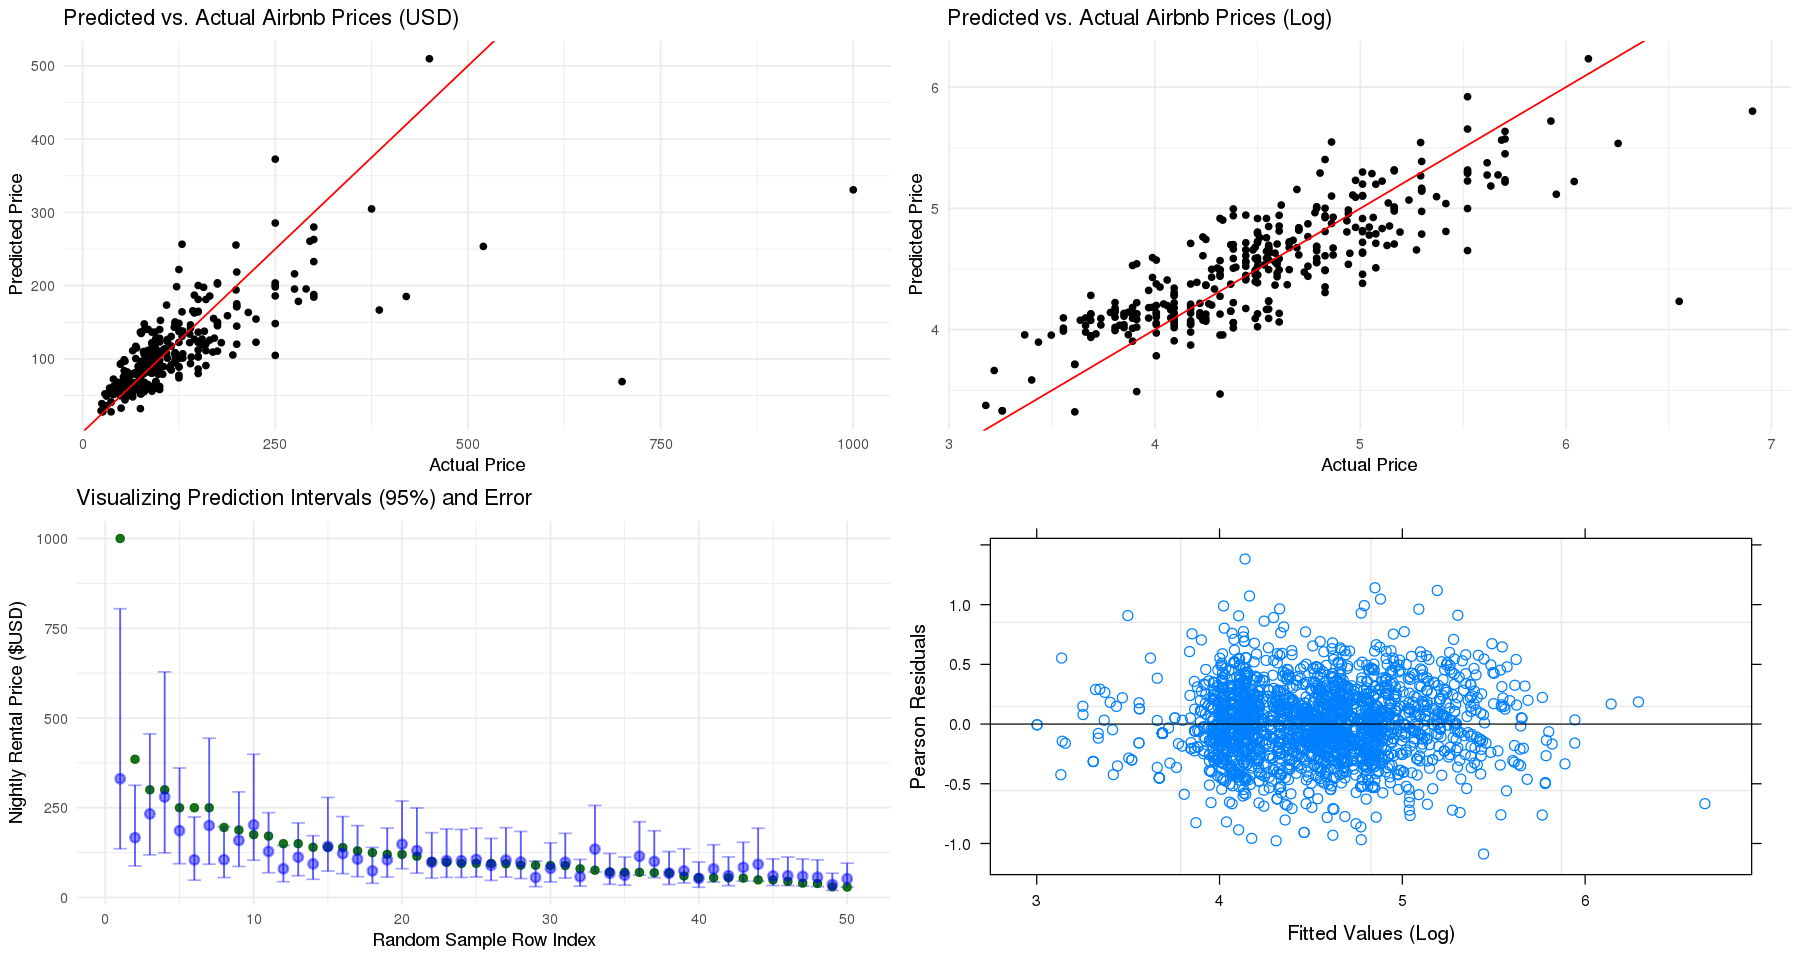

In [17]:
## Convert prices back from log-transformed
preds <- as.data.frame(apply(preds, 2, exp))
preds$actual <- exp(testDF$log_price)

## Actual price vs. predicted price (log and non-log)
p1 <- ggplot(preds, aes(x = actual, y = fit)) + geom_point() + geom_abline(color = 'red') +
        labs(x = "Actual Price", y = "Predicted Price", title = "Predicted vs. Actual Airbnb Prices (USD)") + 
        theme_minimal()
p2 <- ggplot(preds, aes(x = log(preds$actual), y = log(preds$fit))) + geom_point() + geom_abline(color = 'red') +
        labs(x = "Actual Price", y = "Predicted Price", title = "Predicted vs. Actual Airbnb Prices (Log)") +
        theme_minimal()

## Predicted price with confidence intervals and actual price
predsSub <- sample_n(preds, 50)  ## Take a sample of predictions
predsSub <- arrange(predsSub, desc(actual))  ## Arrange by decreasing actual price
predsSub$index <- 1:50  ## Provide index for x-axis

p3 <- ggplot(predsSub, aes(x = index, y = actual)) + 
  geom_errorbar(ymin = predsSub$lwr,
                         ymax = predsSub$upr,
                         color = "BLUE",
                         alpha = 0.35) +
  geom_point(shape = 19,
             alpha = 0.9,
             size = 2,
             color = "DARKGREEN") + 
  geom_pointrange(y = predsSub$fit,
                  x = predsSub$index,
                  ymax = predsSub$upr,
                  ymin = predsSub$lwr,
                  color = 'BLUE',
                  alpha = 0.45) + 
  labs(title = "Visualizing Prediction Intervals (95%) and Error",
       x = 'Random Sample Row Index',
       y = 'Nightly Rental Price ($USD)') + 
  theme_minimal()

## Residuals for mixed-effects regression model
p4 <- plot(portMod, xlab = "Fitted Values (Log)", ylab = "Pearson Residuals")

options(repr.plot.width=15, repr.plot.height=8)

grid.arrange(p1, p2, p3, p4, ncol = 2, nrow = 2)

The two charts on the top row show the actual versus predicted prices, both on the log scale and not.  There's a nice strong correlation - as the actual prices go up, the predicted prices go up.  

On the bottom row, the chart on the left shows us a random sample of predicted prices with their prediction intervals.  It also plots the actual price in green to show when a listed price is outside of the prediction intervals.  **These points would be the ones to focus on when looking for mispriced listings.**  

Finally, the chart on the bottom right shows the distribution of residuals around zero.  This is a nice residuals plot, indicating that we're not missing anything too consistent in the data.

### Final training and evaluation

In [18]:
## Train on full data set, test one more time on validation set
finalModDF <- rbind(trainDF, testDF)

finalMod <- lmer(log_price ~ (1 + compositeSize | neighbourhood_cleansed) +
                            (1 + accommodates | property_type/room_type) +
                            bathrooms + bedrooms + room_type + accommodates,
                data = finalModDF)

validationPreds <- suppressWarnings(predictInterval(merMod = finalMod, newdata = validationDF, 
                                                     level = 0.95, n.sims = 10000,
                                                     stat = "median", type="linear.prediction",
                                                     include.resid.var = TRUE,
                                                     seed = 206))

## Performance evaluation on final model:
display(finalMod)
postResample(exp(validationPreds$fit), exp(validationDF$log_price))

lmer(formula = log_price ~ (1 + compositeSize | neighbourhood_cleansed) + 
    (1 + accommodates | property_type/room_type) + bathrooms + 
    bedrooms + room_type + accommodates, data = finalModDF)
                      coef.est coef.se
(Intercept)            4.16     0.10  
bathrooms              0.14     0.02  
bedrooms               0.16     0.01  
room_typePrivate room -0.46     0.05  
room_typeShared room  -1.17     0.07  
accommodates           0.04     0.03  

Error terms:
 Groups                  Name          Std.Dev. Corr  
 neighbourhood_cleansed  (Intercept)   0.17           
                         compositeSize 0.03     -0.61 
 room_type:property_type (Intercept)   0.13           
                         accommodates  0.07     -0.86 
 property_type           (Intercept)   0.21           
                         accommodates  0.07     -1.00 
 Residual                              0.30           
---
number of obs: 2598, groups: neighbourhood_cleansed, 67; room_type:pro

RMSE   Rsquared 
29.8091891  0.7220295

That's better!  After training the model on everything except the validation set, the r-squared and RMSE values indicate an improved fit so this is the model we will stick with.  

Before exporting the dataset I'm going to add a `price_level` column and summary statistics columns.  These measures will help speed up the performance of our app and make plotting easier.  I'll also subset the reviews dataset to only reviews for listings in the validation set.  

In [19]:
## Create output dataframe
validationPreds <- as.data.frame(apply(validationPreds, 2, exp))  ## Convert prices back from log-transformed
validationPreds$actual <- exp(validationDF$log_price)

validationPreds <- as.data.frame(apply(validationPreds, 2, round)) ## Round prices to nearest whole dollar

outputDF <- cbind(validationDF, validationPreds)  ## Add predictions to original features
outputDF <- left_join(outputDF, portland[, c('id', 'latitude', 'longitude')], by = 'id')  ## Add geospatial coordinates

## Create a flag if the actual price is above or below the upper and lower predicted bounds
outputDF$price_level <- ifelse(outputDF$actual <= outputDF$lwr, "underpriced", "fairly priced")
outputDF[outputDF$actual >= outputDF$upr, "price_level"] <- "overpriced"

## Let's also aggregate some values and prepare our review data set to speed up the performance of our Shiny app
outputDF <- group_by(outputDF, neighbourhood_cleansed) %>% 
    mutate(avg_price = mean(actual), median_price = median(actual))

## Subset reviews for only those listings in the validation set that will be showin in Shiny
portlandReviews <- portlandReviews[portlandReviews$listing_id %in% outputDF$id, ]

### Visualize price levels for listings

If you want the full interactive map experience I suggest you check out the Shiny app that is a companion to this notebook, but for the sake of being thorough here's a plot of properties in the validation set color coded by price level:

In [21]:
head(outputDF)

neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,compositeSize,log_price,id,index,fit,upr,lwr,actual,latitude,longitude,price_level,avg_price,median_price
Irvington,House,Private room,1,1.0,1,1,1.000000,3.891820,4209765,11,56,105,30,49,45.53333,-122.6425,fairly priced,98.83333,90.5
King,House,Private room,2,1.0,1,1,1.354847,4.488636,1280182,83,56,104,31,89,45.56187,-122.6575,fairly priced,66.10000,62.5
King,House,Private room,2,2.0,1,1,1.653090,3.737670,450488,103,64,117,35,42,45.56024,-122.6585,fairly priced,66.10000,62.5
King,House,Private room,2,1.0,1,1,1.354847,3.970292,6263563,130,56,101,31,53,45.55975,-122.6638,fairly priced,66.10000,62.5
King,House,Private room,2,2.0,1,1,1.653090,4.356709,3478041,134,64,118,35,78,45.55608,-122.6555,fairly priced,66.10000,62.5
King,House,Private room,4,1.5,1,2,2.213663,4.174387,4099599,135,73,136,38,65,45.56194,-122.6644,fairly priced,66.10000,62.5


Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=portland&zoom=12&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=portland&sensor=false
Warning message:
“`panel.margin` is deprecated. Please use `panel.spacing` property instead”Warning message:
“Removed 9 rows containing non-finite values (stat_bin2d).”

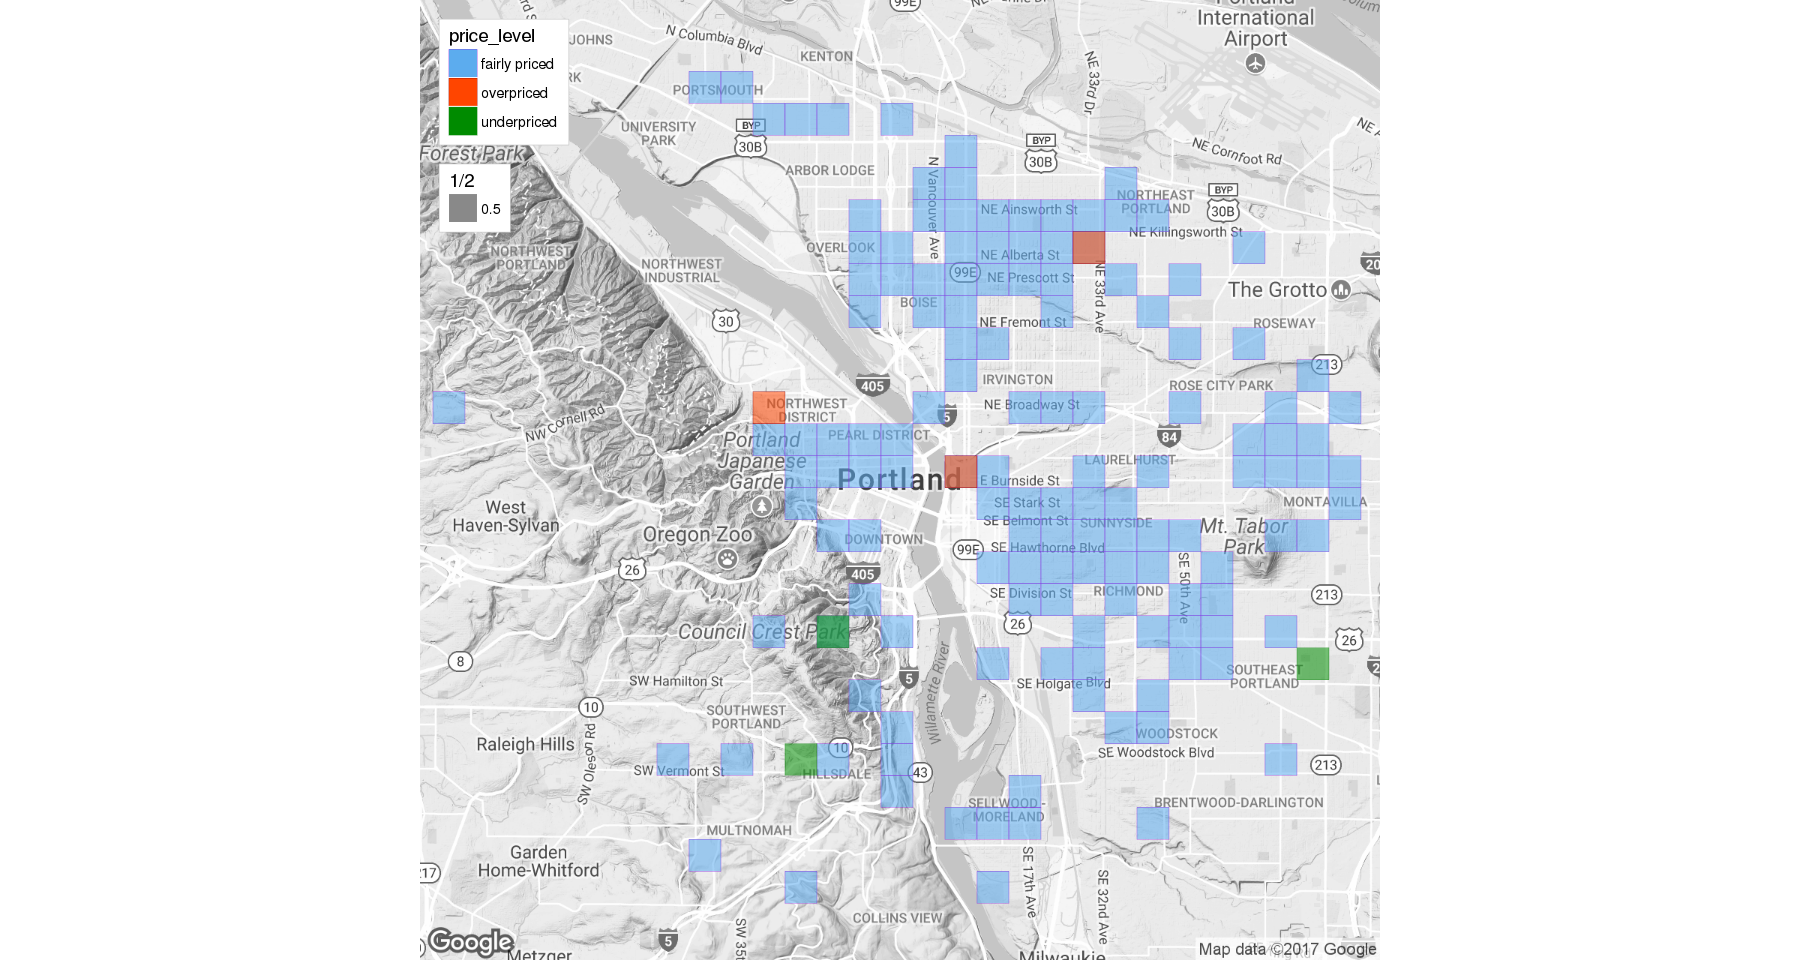

In [22]:
options(repr.plot.width=15, repr.plot.height=8)
ggmap::qmap("portland", zoom = 12, legend = "topleft", maptype = 'terrain', color = 'bw') + 
           stat_bin2d(data = outputDF, aes(x = longitude,
                                           y = latitude, 
                                           fill = price_level, 
                                           color = price_level, 
                                           alpha = 1/2)) +
           scale_colour_manual(values = c("blueviolet", "darkred", "forestgreen")) +
           scale_fill_manual(values = c("steelblue2", "orangered", "green4"))

_______

<a id='export'></a>

## 5. Data and model export

To have an interactive experience with the model in Shiny we'll need to persist a few things to IBM Object Storage:

1. The final model
2. The validation dataset 
3. The reviews for listings in the validation set

The cell below contains the credentials for your Object Storage instance as well as the filenames for each of the objects.  

In [ ]:
## Credentials and libraries to write to object storage
#hidden_cell
## Install necessary library
suppressMessages(install_github('IBMDataScience/objectStoreR')) #installs the package
suppressMessages(library('objectStoreR'))  #loads the package for use

## Provide Credentials


In [ ]:
## Status: 201 is a successful signal
write.csv(outputDF,'portlandWithPredictions.csv', row.names = F)
status <- objectStore.put(creds1,'portlandWithPredictions.csv')
paste("Status for final output CSV:", status, sep = " ")

write.csv(portlandReviews, "portlandReviews.csv", row.names = F)
status <- objectStore.put(creds2, "portlandReviews.csv")
paste("Status for reviews CSV:", status, sep = " ")

saveRDS(object = finalMod, file = "portlandModel.rds")
status <- objectStore.put(creds3, "portlandModel.rds")
paste("Status for model object:", status, sep = " ")

<a id='conclusion'></a>
_______

## 6. Conclusion

Location and size are key drivers of price, even in Yurtlandia.  In addition, our mixed-effects model is sensitive to the fact that the value of size varies from location to location.  Having persisted the model object and predictions in Object Storage we are now in a position to build a Shiny app to take advantage of them.  You can explore the Shiny app by heading to <a href="https://kurlare.shinyapps.io/airbnbml/" target="_blank" rel="noopener no referrer">Shinyapps.io</a>!

<br>
<div><img src="https://raw.githubusercontent.com/kurlare/airbnbFinder/master/Screen%20Shot%202017-05-22%20at%2012.51.42%20PM.png" height = 800 width = 600></div>
<br>

After all that hard work I think we deserve another beautiful picture of Portland, don't you?

<br>
<div><img src="https://upload.wikimedia.org/wikipedia/commons/1/19/Portland_Skyline_glow_July_2017_pan_-_Oregon.jpg" width=800 height = 500></div>
<br>


### Citations

- <a href="http://insideairbnb.com/index.html" target="_blank" rel="noopener no referrer">Inside Airbnb</a>
- <a href="https://www.jaredknowles.com/journal/2013/11/25/getting-started-with-mixed-effect-models-in-r" target="_blank" rel="noopener no referrer">Mixed Effects Models by Jared Knowles</a>
- <a href="https://eurekastatistics.com/calculating-a-distance-matrix-for-geographic-points-using-r/" target="_blank" rel="noopener no referrer">Geospatial Distance Functions by Peter Rosenmai</a>
- Too many StackOverflow questions and answers to count.
- Portland panaroma, Hawthorne bridge photograph, by Cacophony (Own work) <a href="http://www.gnu.org/copyleft/fdl.html">GFDL</a> or <a href="https://creativecommons.org/licenses/by-sa/4.0-3.0-2.5-2.0-1.0">CC BY-SA 4.0-3.0-2.5-2.0-1.0</a>, <a href="https://commons.wikimedia.org/wiki/File%3AHawthorneBridge-Pano.jpg">via Wikimedia Commons</a>
- Portland skyline glow photograph, by M.O. Stevens (Own work) [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0), <a href="https://commons.wikimedia.org/wiki/File%3AHawthorneBridge-Pano.jpg">via Wikimedia Commons</a>


### Author
**Rafi Kurlansik** is an Open Source Solutions Engineer specializing in big data technologies, such as Hadoop and Spark. He's responsible for developing and delivering demonstrations of IBM tech to both enterprise clients and the larger analytics community. Kurlansik has hands-on experience with machine learning, natural language processing, data visualization, and dashboard development. If you're wondering where he comes down on the biggest data science debate of our day, Rafi is, in his own words, "an avid R fan, especially RStudio!"
_______

### Acknowledgements

Thanks to Dale Mumper and Jacques Alcabes for helping me reason through the problem and arrive at a cogent solution. If there are any questions or comments about this project and the methodology, please reach out to me at <rafi.kurlansik@ibm.com>.
_______

Copyright © IBM Corp. 2017. This notebook and its source code are released under the terms of the MIT License.

<div><br><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png" width = 200 height = 200>
</div><br>